# Flask를 활용한 Image Classifier 예제
-참고자료: https://tutorials.pytorch.kr/intermediate/flask_rest_api_tutorial.html

### 필요 라이브러리 설치

In [1]:
!pip install Flask torchvision

     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 133 kB 8.6 MB/s 
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.2
    Uninstalling Jinja2-2.11.2:
      Successfully uninstalled Jinja2-2.11.2


### 모델이 탑재된 Flask 서버를 server.py라는 파일로 저장

In [6]:
%%writefile server.py

import io
import json

from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request


app = Flask(__name__)
imagenet_class_index = json.load(open('data/imagenet_class_index.json'))
model = models.densenet121(pretrained=True)
model.eval()


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = str(y_hat.item())
    return imagenet_class_index[predicted_idx]


@app.route('/', methods=['GET'])
def main():
    return "이곳은 메인페이지 입니다!"

@app.route('/test', methods=['POST'])
def test():
    return "이곳은 테스트입니다!"

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id, class_name = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id, 'class_name': class_name})


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=6006, debug=True)

Overwriting server.py


### 터미널 환경에서 다음 명령어 실행

In [ ]:
# Ai Stages 화면에서 꼭 여러분들의 포트번호를 확인해주세요, 서버마다 다를 수가 있습니다!
#python server.py

### 테스트할 이미지

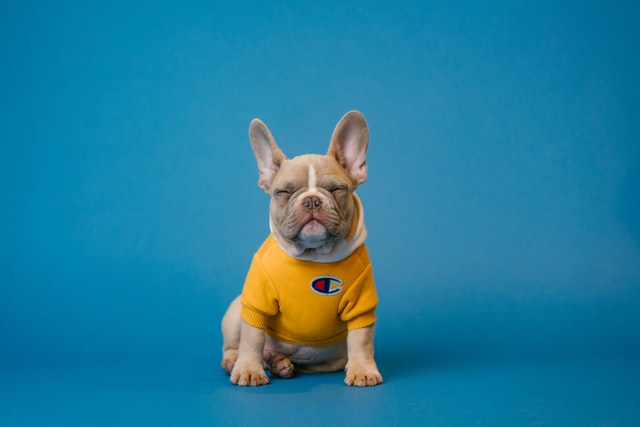

In [7]:
from IPython.display import Image
Image(filename='data/dog.jpeg') 

### 서버에 Post 요청으로 이미지를 전달

- localhost와 127.0.0.1은 동일한 의미: 현재 내 컴퓨터에 요청이라는 의미

In [8]:
import requests
url = 'http://localhost:6006/predict'
files = {'file': open('data/dog.jpeg','rb')}
r = requests.post(url, files=files)
print(r.text)

{
  "class_id": "n02108915", 
  "class_name": "French_bulldog"
}

